# Part 1: Sentiment Analysis

In [ ]:
import pandas as pd

# Load the CSV file
file_path = './data/NEWS_YAHOO_stock_prediction.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
data.head()

In [ ]:
# Step 1: Remove unnecessary column
data.drop(columns=['Unnamed: 0'], inplace=True)

# Step 2: Remove duplicate texts
data.drop_duplicates(subset=['title', 'content'], inplace=True)

# Step 3: Remove rows with large amount of spaces or empty texts in 'title' and 'content'
data = data[~data['title'].str.isspace()]
data = data[~data['content'].str.isspace()]
data.dropna(subset=['title', 'content'], inplace=True)

# Check the dataframe after these preprocessing steps
data.info()

# Step 5: Check for invalid numeric data
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
data[numeric_columns].describe()


In [ ]:
# (optional) set proxy
import subprocess
import os

result = subprocess.run('bash -c "source ~/clash_dir/set && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
output
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

# Load the FinBERT model and tokenizer
checkpoint = 'yiyanghkust/finbert-tone'
tokenizer = BertTokenizer.from_pretrained(checkpoint)
model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

# Create a pipeline for sentiment analysis
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, max_length=512, truncation=True, device=0)

In [ ]:
# Function to apply sentiment analysis to a dataframe
def apply_sentiment_analysis(df, nlp, text_column='content'):
    """
    Apply sentiment analysis to a column in a dataframe.
    
    Args:
    df (pd.DataFrame): Dataframe containing the text data.
    nlp (pipeline): HuggingFace pipeline for sentiment analysis.
    text_column (str): Name of the column containing text data.

    Returns:
    pd.DataFrame: Dataframe with a new column 'sentiment' containing the analysis results.
    """
    # Apply sentiment analysis to each row in the text column
    sentiments = []
    for text in df[text_column]:
        try:
            result = nlp(text)
            sentiments.append(result[0]['label'])
        except Exception as e:
            print(f"Error in processing text: {e}")
            sentiments.append('Error')

    # Add the sentiments as a new column in the dataframe
    df['sentiment'] = sentiments
    return df


In [ ]:
from tqdm.auto import tqdm
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def apply_sentiment_analysis_parallel(df, nlp, text_column='content', batch_size=10):
    """
    Apply sentiment analysis in parallel to a column in a dataframe.

    Args:
    df (pd.DataFrame): Dataframe containing the text data.
    nlp (pipeline): HuggingFace pipeline for sentiment analysis.
    text_column (str): Name of the column containing text data.
    batch_size (int): Number of texts to process in parallel.

    Returns:
    pd.DataFrame: Dataframe with a new column 'sentiment' containing the analysis results.
    """
    # Define a function to process a batch of texts
    def process_batch(texts):
        return [nlp(text)[0]['label'] for text in texts]

    # Break the texts into batches
    batches = [df[text_column][i:i + batch_size] for i in range(0, len(df), batch_size)]

    # Process batches in parallel
    sentiments = []
    with ThreadPoolExecutor() as executor:
        for batch_result in tqdm(executor.map(process_batch, batches), total=len(batches)):
            sentiments.extend(batch_result)

    # Add the sentiments as a new column in the dataframe
    df['sentiment'] = sentiments
    return df


In [ ]:
# Example usage of the function
# Note: You will run this on your local machine as it requires GPU support
sample_texts = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]
sample_df = pd.DataFrame(sample_texts, columns=['content'])
apply_sentiment_analysis(sample_df, nlp)

In [ ]:
# Assuming the apply_sentiment_analysis function is defined as shown previously

# Step 1: Apply sentiment analysis to the dataset
# This step should be done on your local machine due to the requirement of GPU support
data = apply_sentiment_analysis_parallel(data, nlp)

# Step 2: Prepare data for the prediction model
# Here we'll assume the sentiment analysis has been applied and 'sentiment' column is added to the data

# We might want to convert sentiments to numerical values for model training
sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
data['sentiment_numeric'] = data['sentiment'].map(sentiment_mapping)

In [ ]:
# Example code to save the processed DataFrame to a CSV file
data.to_csv('./data/dataset_with_sentiment.csv', index=False)


In [ ]:
# Adjust display settings for better visualization of samples
pd.set_option('display.max_colwidth', 200)  # Adjust the width to fit longer texts

# Display some random samples with formatted output
sample_data = data.sample(n=10)[['content', 'sentiment']]

# Print each sample in a more readable format
for index, row in sample_data.iterrows():
    print(f"Sample {index}:")
    print(f"Content: {row['content']}")
    print(f"Sentiment: {row['sentiment']}\n")


In [ ]:
# Assuming 'data' is your DataFrame with 'sentiment' and 'label' columns
# Calculate the proportion of each sentiment category
sentiment_counts = data['sentiment'].value_counts(normalize=True) * 100

# Calculate the proportion of each label
label_counts = data['label'].value_counts(normalize=True) * 100

# Print the results
print("Sentiment Distribution (%):")
print(sentiment_counts)
print("\nLabel Distribution (%):")
print(label_counts)

# For additional insights, we can also look at the cross-tabulation of sentiment and label
crosstab = pd.crosstab(data['sentiment'], data['label'], normalize='index') * 100
print("\nCross-Tabulation of Sentiment and Label (%):")
print(crosstab)

In [ ]:
# read for existed csv
import pandas as pd
data = pd.read_csv('./data/dataset_with_sentiment.csv')

# Convert the 'Date' column to datetime format and sort the dataframe by 'Date'
data['Date'] = pd.to_datetime(data['Date'])
data_sorted = data.sort_values(by='Date')

In [ ]:
# 按 'Date' 和 'sentiment' 分组，然后计算每个类别的 category 为news和opinion的数量
category_news_per_day_sentiment = data_sorted[data_sorted['category'] == 'news'].groupby(['Date', 'sentiment']).size().unstack().fillna(0)
category_opinion_per_day_sentiment = data_sorted[data_sorted['category'] == 'opinion'].groupby(['Date', 'sentiment']).size().unstack().fillna(0)
# 分别计算news和opinion的total
category_news_total_per_day_sentiment = data_sorted[data_sorted['category'] == 'news'].groupby(['Date']).size()
category_opinion_total_per_day_sentiment = data_sorted[data_sorted['category'] == 'opinion'].groupby(['Date']).size()

data_sorted = data_sorted.set_index('Date')
data_sorted['P_news_pos'] = category_news_per_day_sentiment['Positive'].reindex(data_sorted.index) / category_news_total_per_day_sentiment.reindex(data_sorted.index)
data_sorted['P_news_neg'] = category_news_per_day_sentiment['Negative'].reindex(data_sorted.index) / category_news_total_per_day_sentiment.reindex(data_sorted.index)
data_sorted['P_op_pos'] = category_opinion_per_day_sentiment['Positive'].reindex(data_sorted.index) / category_opinion_total_per_day_sentiment.reindex(data_sorted.index)
data_sorted['P_op_neg'] = category_opinion_per_day_sentiment['Negative'].reindex(data_sorted.index) / category_opinion_total_per_day_sentiment.reindex(data_sorted.index)
data_sorted = data_sorted.reset_index()

In [ ]:
daily_data = data_sorted.groupby('Date').last()

# Shift the 'Open' column to get the next day's opening price
daily_data['Next_Open'] = daily_data['Open'].shift(-1)

# Drop the last row as it will not have a 'Next_Open' value
daily_data = daily_data[:-1]

In [ ]:
date_to_query = pd.to_datetime('2016-10-28')
daily_data.loc[(date_to_query)]

In [ ]:
date_to_query = pd.to_datetime('2016-10-28')
data_sorted.loc[data_sorted['Date'] == date_to_query]

In [ ]:
date_to_query = pd.to_datetime('2020-01-23')
daily_data.loc[(date_to_query)]

In [ ]:
date_to_query = pd.to_datetime('2018-05-06')
category_to_query = 'news'
data_sorted.loc[(data_sorted['Date'] == date_to_query) & (data_sorted['category'] == category_to_query)]

In [ ]:
daily_data['P_news_neg'].fillna(0, inplace=True)
daily_data['P_news_pos'].fillna(0, inplace=True)
daily_data['P_op_neg'].fillna(0, inplace=True)
daily_data['P_op_pos'].fillna(0, inplace=True)

In [ ]:
# 不直接删除，而是存到新的df中。保留'date'列
columns_to_keep = [col for col in daily_data.columns if col not in ['ticker', 'Adj Close', 'sentiment', 'sentiment_numeric', 'title', 'category', 'content', 'label']]
daily_data_selected = daily_data[columns_to_keep]

In [ ]:
daily_data_selected.to_csv('./data/dataset_for_model.csv', index=False)

# Part 2: Stock price prediction

In [12]:
import pandas as pd
daily_data_selected = pd.read_csv('./data/dataset_for_model.csv')

In [13]:
# 选择特征和目标
features = daily_data_selected.drop('Next_Open', axis=1)
target = daily_data_selected['Next_Open']

# normalization
from sklearn.preprocessing import MinMaxScaler

# Apply the MinMaxScaler to the features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# fit_transform根据数据计算缩放参数
scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# 保存缩放参数
import joblib
joblib.dump(scaler_features, './model/scaler_features.pkl')
joblib.dump(scaler_target, './model/scaler_target.pkl')

# Create new DataFrames with the scaled features and target
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_target_df = pd.DataFrame(scaled_target, columns=['Next_Open'])

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [15]:
def create_sequences(features, targets, seq_length):
    """
    Create sequences of specified length from time series data.

    Args:
    features (np.array): The feature data.
    targets (np.array): The target data.
    seq_length (int): The length of the sequence.

    Returns:
    np.array: Sequences of features.
    np.array: Corresponding targets for each sequence.
    """
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x = features[i:(i + seq_length)]
        y = targets[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Example sequence length
seq_length = 15

# Create sequences
features_seq, target_seq = create_sequences(scaled_features, scaled_target, seq_length)

# Convert sequences to Tensor
features_tensor = torch.tensor(features_seq, dtype=torch.float32)
target_tensor = torch.tensor(target_seq, dtype=torch.float32)

In [16]:
# 划分训练集、验证集、测试集
train_features, test_features, train_target, test_target = train_test_split(
    scaled_features, scaled_target, test_size=0.2, random_state=42
)

val_features, test_features, val_target, test_target = train_test_split(
    test_features, test_target, test_size=0.5, random_state=42
)

# 创建TensorDataset
train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32),
                              torch.tensor(train_target, dtype=torch.float32))

val_dataset = TensorDataset(torch.tensor(val_features, dtype=torch.float32),
                            torch.tensor(val_target, dtype=torch.float32))

test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32),
                             torch.tensor(test_target, dtype=torch.float32))

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [17]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size, 1)

    def forward(self, hidden, encoder_outputs):
        attn_weights = torch.tanh(self.attn(encoder_outputs))
        return torch.bmm(attn_weights.transpose(1, 2), encoder_outputs).squeeze(1)

class AttentionLSTM(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, output_dim, dropout=0.2):
        super(AttentionLSTM, self).__init__()
        self.hidden_size = hidden_size

        # LSTM层
        self.lstm = nn.LSTM(input_dim, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # 注意力层
        self.attention = Attention(hidden_size)
        
        # 全连接层
        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # 确保 lstm_out 是三维的
        if lstm_out.dim() == 2:
            lstm_out = lstm_out.unsqueeze(0)
        attn_out = self.attention(lstm_out[:, -1, :], lstm_out)
        output = self.fc(attn_out)
        return output


In [18]:
# Hyperparameters
input_dim = scaled_features_df.shape[1]  # Number of features
hidden_size = 50  # Number of features in hidden state, can be adjusted
num_layers = 2    # Number of stacked LSTM layers
output_dim = 1    # Number of output dimensions (predicting one value)

# 实例化模型时添加Dropout
model = AttentionLSTM(input_dim, hidden_size, num_layers, output_dim)

In [19]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 30  # Can be adjusted

# 在训练循环中添加对验证集的检查
best_val_loss = float('inf')
# Training loop
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # 在每个epoch结束后评估验证集
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
    val_loss /= len(val_loader)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    print(f'Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss}')
    
    # 检查是否有更低的验证损失
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './model/best_model.pth')  # 保存最好的模型

/root/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/root/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/root/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  r

Epoch 1/30, Loss: 0.11083133518695831
Epoch 1, Training Loss: 0.11083133518695831, Validation Loss: 0.038211681569616
Epoch 2/30, Loss: 0.045867741107940674
Epoch 2, Training Loss: 0.045867741107940674, Validation Loss: 0.03803865611553192
Epoch 3/30, Loss: 0.12903812527656555
Epoch 3, Training Loss: 0.12903812527656555, Validation Loss: 0.037758076563477516
Epoch 4/30, Loss: 0.08853752911090851
Epoch 4, Training Loss: 0.08853752911090851, Validation Loss: 0.037648885510861874
Epoch 5/30, Loss: 0.05050080269575119
Epoch 5, Training Loss: 0.05050080269575119, Validation Loss: 0.037495837857325874
Epoch 6/30, Loss: 0.10237488895654678
Epoch 6, Training Loss: 0.10237488895654678, Validation Loss: 0.037932686507701874
Epoch 7/30, Loss: 0.15143339335918427
Epoch 7, Training Loss: 0.15143339335918427, Validation Loss: 0.037221054236094155
Epoch 8/30, Loss: 0.04065785929560661
Epoch 8, Training Loss: 0.04065785929560661, Validation Loss: 0.03952401907493671
Epoch 9/30, Loss: 0.111138202250003

In [20]:
import matplotlib.dates as mdates

# 加载最佳模型
model.load_state_dict(torch.load('./model/best_model.pth'))

# 提取最后n个数据点
test_length = 300
last_n = daily_data_selected[-test_length:]

# 保存最后n个日期，这将用于绘图
last_n_dates = last_n.index

# 删除日期和目标列以准备缩放
last_n_features = last_n.drop(['Next_Open'], axis=1)
last_n_target = last_n['Next_Open']

In [21]:
# 仅在scaler_features/scaler_target在当前内存中不存在时，才从文件中加载保存的缩放器状态
if 'scaler_features' not in locals():
    scaler_features = joblib.load('./model/scaler_features.pkl')
if 'scaler_target' not in locals():
    scaler_target = joblib.load('./model/scaler_target.pkl')

# 缩放特征
# transform应用此前的缩放参数，而不要重新计算
last_n_scaled_features = scaler_features.transform(last_n_features)

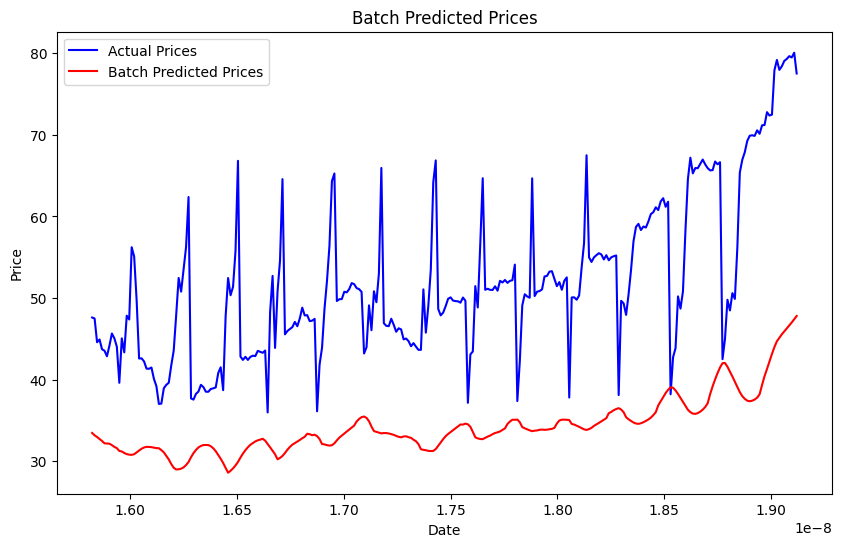

In [22]:

# 定义窗口长度
window_length = seq_length  # 根据您的模型调整

# 创建包含所有窗口的数据集
batched_windows = []
for i in range(test_length - window_length + 1):
    window = last_n_scaled_features[i:i + window_length]
    batched_windows.append(window)
batched_windows = np.array(batched_windows)

# 将数据转换为Tensor
batched_windows_tensor = torch.tensor(batched_windows, dtype=torch.float32)

# 使用模型进行预测
model.eval()
with torch.no_grad():
    batch_predictions = model(batched_windows_tensor).numpy()

# 反缩放预测值
batch_predictions = scaler_target.inverse_transform(batch_predictions).flatten()

# 绘制实际股价和批量预测股价的对比图
plt.figure(figsize=(10, 6))
plt.plot(mdates.date2num(last_n_dates[window_length - 1:]), last_n_target[window_length - 1:], label='Actual Prices', color='blue')
plt.plot(mdates.date2num(last_n_dates[window_length - 1:]), batch_predictions, label='Batch Predicted Prices', color='red')
plt.title('Batch Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
# 滑动窗口预测
true_predictions = []
for i in range(test_length):
    if i < window_length:
        continue
    window = last_n_scaled_features[i-window_length:i]
    window_tensor = torch.tensor(window, dtype=torch.float32).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        prediction = model(window_tensor).numpy()
    true_prediction = scaler_target.inverse_transform(prediction).flatten()[0]
    true_predictions.append(true_prediction)
    
# 绘制第一张图 
plt.figure(figsize=(10, 6))
# TODO
plt.plot(last_n_dates, last_n_target, label='Actual Prices', color='blue')
plt.plot(last_n_dates[window_length:], true_predictions, label='Predicted Prices', color='red')
plt.title('Sliding Window Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
# 递归预测
recursive_predictions = last_n_scaled_features[-window_length:].tolist()  # 初始窗口
for i in range(test_length // 2):
    window_tensor = torch.tensor(recursive_predictions[-window_length:], dtype=torch.float32).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        prediction = model(window_tensor).numpy()
    recursive_predictions.append(prediction[0])

# 反缩放递归预测
recursive_predictions = scaler_target.inverse_transform(np.array(recursive_predictions).reshape(-1, 1)).flatten()

# 绘制第二张图
plt.figure(figsize=(10, 6))
plt.plot(last_n_dates, last_n_target, label='Actual Prices', color='blue')
plt.plot(last_n_dates, recursive_predictions[:test_length], label='Recursive Predicted Prices', color='red')
plt.title('Recursive Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
# 假设您的模型已经被训练并准备好进行预测
# 我们将使用最后一个时间窗口的数据来预测接下来的n个时间点
# 为此，我们需要从数据集的末尾向前回溯一个窗口长度的数据点

# 定义窗口长度
window_length = 15  # 与您模型训练时使用的序列长度一致

# 预测未来n个时间点的函数
def predict_next_n(model, last_window_data, num_predictions=n):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    current_window = last_window_data
    
    with torch.no_grad():
        for _ in range(num_predictions):
            # 使用当前窗口数据进行预测
            current_window_tensor = torch.tensor(current_window, dtype=torch.float32).unsqueeze(0)  # 增加batch维度
            prediction = model(current_window_tensor)
            prediction = prediction.numpy().flatten()[0]  # 将预测结果转换为numpy并提取数值
            predictions.append(prediction)
            
            # 更新窗口数据：移除最早的点，加入最新预测
            current_window = np.roll(current_window, -1)
            current_window[-1] = prediction  # 这里假设您的目标是最后一个特征

    return predictions

# 获取最后一个时间窗口的数据
last_window_data = last_n_scaled_features[-window_length:]

# 预测下一个n个时间点
next_n_predictions_scaled = predict_next_n(model, last_window_data)

# 反缩放预测值
next_n_predictions = scaler_target.inverse_transform(np.array(next_n_predictions_scaled).reshape(-1, 1))

# 现在您有了未来n个时间点的预测，可以与实际数据进行比较
